In [50]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color_sns = sns.cubehelix_palette(8, start=.5, rot=-.75)

# Rocksdb

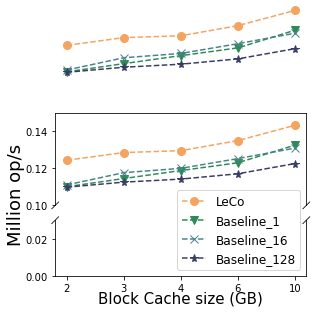

In [3]:
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from brokenaxes import brokenaxes
Baseline = [0.110038,0.114483,0.118789,0.122976,0.132508]
Baseline_16=[0.111025,0.117650,0.119981,0.125244,0.130878]
Baseline_128 = [0.109812,0.112544,0.114175,0.117051,0.122561]
Leco=[0.124348,0.128505,0.129521,0.134952,0.143202]
label = ['LeCo','Baseline_1','Baseline_16','Baseline_128']
dataset = [Leco,Baseline, Baseline_16,Baseline_128]
mark_style = ['o','v','x','*']
colors = ['sandybrown','lightseagreen','seagreen', 'slategray']
colors =  ['sandybrown','seagreen', color_sns[4],color_sns[6]]
plt.figure(figsize=(4.5, 3))
bax = brokenaxes( ylims=[(0, 0.03), (0.1, 0.15)], despine=False)
for i in range(len(dataset)):
    bax.plot(dataset[i],ls='--',marker=mark_style[i],label = label[i], c = colors[i],ms=8,clip_on=False)

bax.set_ylabel('Million op/s',fontsize=18)
bax.set_xlabel('Block Cache size (GB)',fontsize=15)
# plt.title('Rocksdb index block',fontsize=23)
# plt.ylim([0,0.16])
bax.set_xticks([0,1,2,3,4],['2','3','4','6','10'], fontsize=10)
# bax.set_yticks(fontsize=10)
for i in range(2):
    for tick in bax.axs[i].get_yaxis().get_major_ticks():
        tick.label.set_fontsize(10)
bax.legend(fontsize=12, loc=4)
# plt.tight_layout()
# plt.subplots_adjust(left=0.12, right=0.97, bottom=0.2, top=0.95)
plt.savefig("Rocksdb.pdf", bbox_inches='tight', pad_inches=0.05, transparent=True)
# plt.savefig('Rocksdb.pdf',dpi=500, transparent=True)
plt.show()


# Parquet

scale: linear


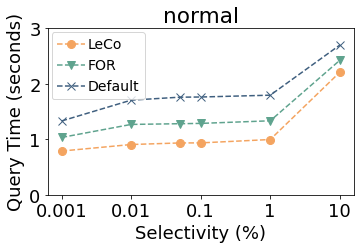

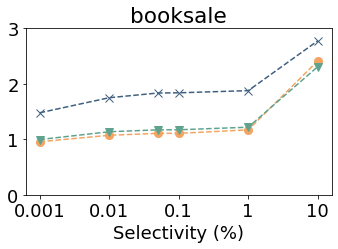

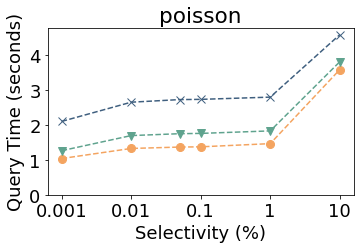

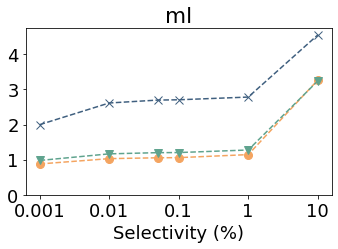

In [9]:
from curses.panel import bottom_panel
from logging import StrFormatStyle

PROJ_SRC_DIR = '/root/arrow-private/cpp'
# name='20220904_143952.csv'
# name = f'{PROJ_SRC_DIR}/output/20220905_140614.csv'
# name = f'{PROJ_SRC_DIR}/output/20220913_193623.csv'
# name = f'{PROJ_SRC_DIR}/output/20220914_145832_1M.csv'
# name = f'{PROJ_SRC_DIR}/output/20220916_132957.csv' # no zstd
# name = f'{PROJ_SRC_DIR}/output/20220916_001025.csv' # zstd
# name = f'{PROJ_SRC_DIR}/output/20220917_162524.csv' # add wiki large
# name = 'leco_pq_i3g.csv'
name = 'i3g_new.csv'

matplotlib.rcParams.update({'font.size': 18})
from matplotlib.ticker import *

df = pd.read_csv(name) 
# print(df)
df_avg = df.groupby(['dataset', 'encoding','selectivity'], as_index=False).mean().set_index(['dataset','encoding'])

df_avg = df_avg.drop(['PLAIN'], axis=0, level=1)
# print(df_avg)
# print(df_avg.loc['books_200M_uint32.txt', 'DICT'])
dataset_dict = set()
encoding_dict = set()
for i, row in df_avg.iterrows():   
    dataset_dict.add(i[0])
    encoding_dict.add(i[1])

dataset_dict = ['normal_200M_uint32.txt', 'books_200M_uint32.txt',
 'poisson_timestamps_EVENT_50000_SENSOR_2000_randomdie_OUTER_1000s_INNER_2ms_200M.csv', 'ml_timestamp_200M.csv']

scale = ['linear']
ds_to_title = {'linear_200M_uint32.txt': 'linear', 'books_200M_uint32.txt': 'booksale',
 'wiki_200M_uint64': 'wiki', 'normal_200M_uint32.txt': 'normal', 'ml_timestamp_200M.csv': 'ml', 
 'poisson_timestamps_EVENT_50000_SENSOR_2000_randomdie_OUTER_1000s_INNER_2ms_200M.csv': 'poisson'}
enc_to_label = {'LECO': 'LeCo', 'FOR': 'FOR', 'DICT': 'Default', 'PLAIN': 'Plain'}
encoding_dict = ['LECO','FOR','DICT']
# marker = ["^", "o", "s", "x"]
marker = ['o','v','x']
colors = ['sandybrown',color_sns[3],color_sns[5]]

for s in scale:
    print(f'scale: {s}')
    cnt = 0
    for ds in dataset_dict:
        fig, ax = plt.subplots(figsize=(5, 3.3))
        for i, enc in enumerate(encoding_dict):
            # print(ds, enc)
            # print(df_avg.loc[ds, enc])
            ax.plot(df_avg.loc[ds, enc]['selectivity'], df_avg.loc[ds, enc]['query_time'], label=enc_to_label[enc], marker=marker[i], color=colors[i], ls='--', ms=8)
        
        # speedup txt code, should comment off
        # speedup_over_default = df_avg.loc[ds, 'DICT']['query_time'].values / df_avg.loc[ds, 'LECO']['query_time'].values
        # speedup_over_for = df_avg.loc[ds, 'FOR']['query_time'].values / df_avg.loc[ds, 'LECO']['query_time'].values
        # speedup_xspace, speedup_yspace = 0, 0.1
        # print(speedup_over_default)
        # print(speedup_over_for)
        # for x, y, s in zip(df_avg.loc[ds, 'DICT']['selectivity'], df_avg.loc[ds, 'DICT']['query_time'], speedup_over_default):
        #     ax.text(x + speedup_xspace, y + speedup_yspace, "%.1fx"%(s), fontsize=12)
        
        # for x, y, s in zip(df_avg.loc[ds, 'FOR']['selectivity'], df_avg.loc[ds, 'FOR']['query_time'], speedup_over_for):
        #     ax.text(x + speedup_xspace, y + speedup_yspace, "%.1fx"%(s), fontsize=12)

        # ax.set_yscale(s)
        ax.set_xscale('log')
        ax.set_xticks([0.001, 0.01, 0.1, 1.0, 10])
        if cnt == 0 or cnt == 1:
            ax.set_yticks([0, 1, 2, 3])
        else:
            ax.set_yticks([0, 1, 2, 3, 4])
        ax.xaxis.set_major_formatter('{x:g}')
        ax.set_ylim(bottom=0)
        if cnt == 0:
            ax.legend(loc="upper left", bbox_to_anchor=((-0.01,1.02)), ncol=1, frameon=True,
                        prop={'size': 14}, columnspacing=1, handletextpad=0.2)
        ax.set_xlabel('Selectivity (%)')
        if cnt % 2 == 0:
            ax.set_ylabel('Query Time (seconds)')
        # ax.set_title(ds_to_title[ds])
        # plt.tight_layout()
        plt.title(ds_to_title[ds])
        plt.subplots_adjust(left=0.12, right=0.97, bottom=0.2, top=0.9)
        plt.savefig(f'leco_pq_{ds_to_title[ds]}.pdf')
        plt.show()
        cnt += 1
# df_avg.loc['books_200M_uint32.txt', 'DICT'].plot(x='selectivity', y='query_time', label='DICT')
# df_avg.plot()
# plt.show()

In [10]:
import scipy.stats
dist = scipy.stats.binom(1, 0.5)

In [11]:
import numpy as np
NUM_KEYS = 100
prob_ = 0.4
keys1 = np.random.choice([0, 1], size=NUM_KEYS//2, p=[1.0-prob_*0.1, prob_*0.1])
keys2 = np.random.choice([0, 1], size=NUM_KEYS//2, p=[1.0-prob_*1.9, prob_*1.9])
print(np.concatenate((keys1, keys2)))
# print(type(keys1))
# print(np.concatenate(np.array(keys1).astype(np.uint32), np.array(keys2).astype(np.uint32)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0]


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
name = 'zstd_result_new.csv'
encoding_map = {'DICT': 8, 'FOR': 10, 'LECO': 11}
encoding_names = []
for enc in encoding_map.keys():
        encoding_names.append(enc_to_label[enc])
df = pd.read_csv(name) 
df = df[df['encoding'] != 'PLAIN']
colors = ['darkseagreen','seagreen','sandybrown']
# print(df)
barWidth = 0.1
cnt = 0
zstd_cr_total = []
for ds in dataset_dict:
    no_zstd_res = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'size']
    #divide all values in no_zstd_res by 1024
    no_zstd_res = no_zstd_res / 1024 / 1024
    zstd_res = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'size']
    zstd_res = zstd_res / 1024 / 1024
    no_zstd_enc = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'encoding']
    zstd_enc = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'encoding']
    zstd_cr = no_zstd_res.to_numpy().flatten() / zstd_res.to_numpy().flatten()
    zstd_cr_total.extend(zstd_cr)
    # print(no_zstd_res)
    # print(zstd_res)
    # print(no_zstd_enc)
    # print(zstd_enc)

In [48]:
def create_multi_bars(labels, datas, name, zstd_res_total, tick_step=1.5, group_gap=0.15, bar_gap=0):
    codec = ['Default', 'Default-ZSTD', 'FOR', 'FOR-ZSTD', 'LeCo', 'LeCo-ZSTD']
#     category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, len(data)))
    category_colors = ['steelblue','lightsteelblue','seagreen','darkseagreen','sandybrown','peachpuff']
    category_colors = [color_sns[6],color_sns[5],color_sns[3],color_sns[1],'sandybrown','peachpuff']
    ticks = np.arange(len(labels)) * tick_step
    group_num = len(datas)
    group_width = tick_step - group_gap
    bar_span = group_width / group_num
    bar_width = bar_span - bar_gap
    baseline_x = ticks - (group_width - bar_span) / 2
    plt.figure(figsize=(16, 5))

    plt.ylabel('File Size (MB)',fontsize=37)
    for index, y in enumerate(datas):
        plt.bar(baseline_x + index*bar_span, y, bar_width, label =codec[index],color = category_colors[index] )
        
    gap = baseline_x[1] - baseline_x[0]
    for i in range(len(labels)):
        zstd_cr_tmp = zstd_cr_total[(0 + i*3): (3 + i*3)]
        zstd_res_tmp = zstd_res_total[(0 + i*3): (3 + i*3)]
        speedup_xspace, speedup_yspace = -0.4 + i * gap, 20
        for x, y, s in zip([bar_width*r*2 for r in range(len(zstd_res_tmp))], 
                zstd_res_tmp, zstd_cr_tmp):
            plt.text(x + speedup_xspace-0.06, y + speedup_yspace,
                "%.1fx"%(s), fontsize=20)
    plt.legend(fontsize=21)
    # plt.ylim([0,4])
    ax = plt.gca()
    ymajorLocator = MultipleLocator(500)
    ax.yaxis.set_major_locator(ymajorLocator)
    # ymajorLocator = MultipleLocator(1.0)
    # ax.yaxis.set_major_locator(ymajorLocator)
    # ymajorFormatter = FormatStrFormatter('%1.1f')
    # ax.yaxis.set_major_formatter(ymajorFormatter)
#     ax.yaxis.tick_right()
    plt.xlim([min(baseline_x)-0.2, max(baseline_x)+1.5])
    plt.yticks(fontsize=22)
    plt.xticks(ticks, labels, fontsize=30)
    plt.tight_layout()
    plt.savefig(f'zstd_{name}.pdf',dpi=500, transparent=True)
    plt.show()

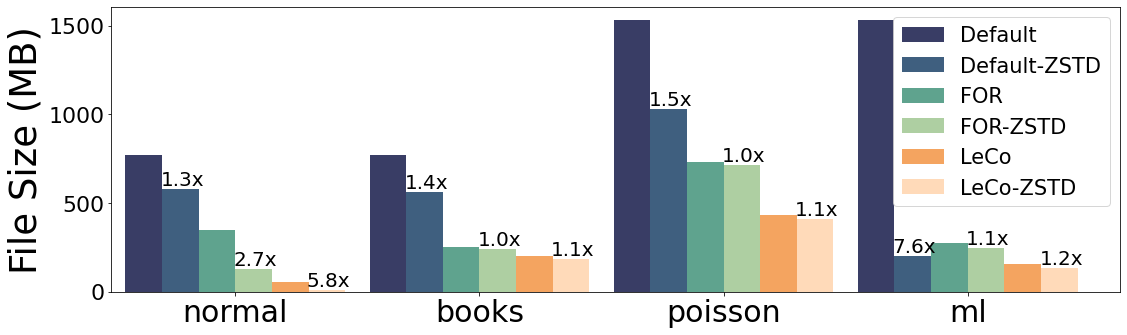

In [49]:
labels = ['normal', 'books', 'poisson', 'ml']
datas = [[], [], [], [], [], []]
zstd_res_total = []
for ds in dataset_dict:
    no_zstd_res = df.loc[(df['file'] == ds) & (df['compression'].isnull()), 'size']
    #divide all values in no_zstd_res by 1024
    no_zstd_res = list(no_zstd_res / 1024 / 1024)
    zstd_res = df.loc[(df['file'] == ds) & (df['compression'] == '.zstd'), 'size']
    zstd_res = list(zstd_res / 1024 / 1024)
    zstd_res_total.extend(zstd_res)
    data = []
    for i in range(len(no_zstd_res)):
        datas[i*2].append(no_zstd_res[i])
        datas[i*2 + 1].append(zstd_res[i])
create_multi_bars(labels, datas, 'total', zstd_res_total)